# Reward competition distance from port analysis

Brief 1-2 sentence description of notebook.

In [24]:
import glob
from datetime import datetime
from functools import reduce


In [42]:
# Imports of all used packages and libraries
import pandas as pd
import h5py

## Inputs & Data

Explanation of each input and where it comes from.

In [3]:
# Inputs and Required data loading
# input varaible names are in all caps snake case
# Whenever an input changes or is used for processing 
# the vairables are all lower in snake case
OUTPUT_DIR = "./proc" # where data is saved should always be shown in the inputs
# ITIs from MED-PC code
ALL_ITIS = [80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 120, 80, 95, 80, 90, 80, 75, 100, 95, 90, 80, 90, 100, 90, 120, 90, 85, 90, 95, 90, 80, 90, 100, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90 ]
# Converting the seconds into frames
ALL_ITIS = [num * 30 for num in ALL_ITIS]

In [4]:
TONE_START_DF = pd.read_excel("./data/reward_comp_tone_sleap_frames.xlsx")

## Outputs

Describe each output that the notebook creates. 

- Is it a plot or is it data?

- How valuable is the output and why is it valuable or useful?

## Functions

In [5]:
# As much code and as many cells as required
# includes EDA and playing with data
# GO HAM!

# Ideally functions are defined here first and then data is processed using the functions

# function names are short and in snake case all lowercase
# a function name should be unique but does not have to describe the function
# doc strings describe functions not function names



In [6]:

def get_running_total(lst: list) -> list:
    """
    Compute the running total for a list of numbers.
    
    Given a list of numbers, this function returns a new list 
    where each element is the cumulative sum of the elements 
    up to that point in the original list.

    Parameters:
    - lst (list): A list of numbers.

    Returns:
    - list: A list containing the running total.

    Example:
    >>> get_running_total([1, 2, 3, 4])
    [1, 3, 6, 10]
    """

    def accumulator(acc, x):
        if acc:
            return acc + [acc[-1] + x]
        else:
            return [x]
        
    return reduce(accumulator, lst, [])

In [41]:

def extract_sleap_data_from_h5(filename: str) -> tuple:
    """
    Extract relevant SLEAP data from an h5 file.

    Given a filename for an h5 file, this function retrieves:
    - locations of the tracks,
    - names of the nodes,
    - names of the tracks.

    Parameters:
    - filename (str): The path to the h5 file.

    Returns:
    - tuple: A tuple containing:
      * locations (numpy.ndarray): Array of track locations.
      * node_names (list[str]): List of node names.
      * track_names (list[str]): List of track names.

    Example:
    >>> locations, node_names, track_names = extract_sleap_data_from_h5("path/to/file.h5")
    """

    with h5py.File(filename, "r") as f:
        locations = f["tracks"][:].T
        node_names = [n.decode() for n in f["node_names"][:]]
        track_names = [n.decode() for n in f["track_names"][:]]
    
    return locations, node_names, track_names

## Processing

Describe what is done to the data here and how inputs are manipulated to generate outputs. 

- Getting the file name as opposed to the whole path

In [7]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain
0,10-03-22_Test_1_1-1v1-2,2135,30,C57
1,10-03-22_Test_2_1-3v1-4,2123,29,C57
2,10-03-22_Test_3_2-1v2-2,2125,29,C57
3,10-03-22_Test_13_2-2v2-4,2138,30,C57
4,10-03-22_Test_14_2-1v2-3,2127,29,C57


- Removing "fixed" as part of the file name

In [8]:
TONE_START_DF["file_base"] = TONE_START_DF["File Name"].apply(lambda x: x.split(".")[0])

- Getting the date based on the file base

In [9]:
TONE_START_DF["date"] = TONE_START_DF["file_base"].apply(lambda x: datetime.strptime(x.split("_")[0].strip(""), '%m-%d-%y').strftime('%Y-%m-%d'))



In [10]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03


- Getting the subject name from the file name

In [11]:
TONE_START_DF["all_subj"] = TONE_START_DF["file_base"].apply(lambda x: sorted(x.split("_")[-1].split(".")[0].split("v")))

- Replacing the hyphen with a period so that we have a shared ID across datasets

In [12]:
TONE_START_DF["all_subj"] = TONE_START_DF["all_subj"].apply(lambda x: tuple([subj.replace("-", ".").strip() for subj in x]))

In [13]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)"
3,10-03-22_Test_13_2-2v2-4,2138,30,C57,10-03-22_Test_13_2-2v2-4,2022-10-03,"(2.2, 2.4)"
4,10-03-22_Test_14_2-1v2-3,2127,29,C57,10-03-22_Test_14_2-1v2-3,2022-10-03,"(2.1, 2.3)"


- Making separate rows for each subject

In [14]:
TONE_START_DF["subj_id"] = TONE_START_DF["all_subj"]

In [15]:
TONE_START_DF = TONE_START_DF.explode(column="subj_id")

In [16]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1


- Getting the index of the subject from the tuple of both subjects

In [17]:
TONE_START_DF["subj_index"] = TONE_START_DF.apply(lambda x: list(x["all_subj"]).index(x["subj_id"]), axis=1)

In [18]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0


- Dropping all rows that don't have numbers for frame start

In [19]:
TONE_START_DF = TONE_START_DF[TONE_START_DF["Frame Start"].astype(str).str.isnumeric()]

In [20]:
TONE_START_DF["Frame Start"] = TONE_START_DF["Frame Start"].astype(int)

In [21]:
TONE_START_DF["all_tone_frame"] = TONE_START_DF.apply(lambda row: get_running_total([row["Frame Start"]] + ALL_ITIS), axis=1)

In [38]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ..."
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ..."


# Get Coordinates of all the corners

- Reading in all the files with the corner coordinate and the pose tracking"

In [25]:
all_corner_h5 = glob.glob("./data/corner_labeling/*.corner.h5")

In [26]:
all_pose_estimation_h5 = glob.glob("./data/sleap_pose_tracking/*.h5")

In [32]:
all_corner_h5[:5]

['./data/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5',
 './data/corner_labeling/10-03-22_Test_15_1-2v1-4.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_19_4-1v4-3.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_15_6-1v6-3.fixed.corner.h5',
 './data/corner_labeling/10-04-22_Test_11_1-1v1-4.fixed.corner.h5']

In [33]:
all_pose_estimation_h5[:5]

['./data/sleap_pose_tracking/10-03-22_Test_7_4-1v4-2.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-04-22_Test_8_3-2v3-3.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-03-22_Test_8_4-3v4-4.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-03-22_Test_19_3-2v3-4.fixed.analysis.h5',
 './data/sleap_pose_tracking/10-04-22_Test_16_6-2v6-4.fixed.analysis.h5']

In [27]:
len(all_corner_h5)

33

In [28]:
len(all_pose_estimation_h5)

33

- Matching all the video file names to the corresponding corner and pose tracking coordinate file

In [29]:
file_name_to_corner = {item.split("/")[-1].split(".")[0].strip(): item for item in all_corner_h5}

In [30]:
file_name_to_pose_estimation = {item.split("/")[-1].split(".")[0].strip(): item for item in all_pose_estimation_h5}

In [36]:
file_name_to_corner[list(file_name_to_corner.keys())[0]]

'./data/corner_labeling/10-04-22_Test_21_1-1v1-3.fixed.corner.h5'

In [39]:
TONE_START_DF["corner_file"] = TONE_START_DF["File Name"].map(file_name_to_corner)
TONE_START_DF["pose_estimation_file"] = TONE_START_DF["File Name"].map(file_name_to_pose_estimation)

In [40]:
TONE_START_DF.head()

,File Name,Frame Start,FPS,Strain,file_base,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,10-03-22_Test_1_1-1v1-2,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,10-03-22_Test_2_1-3v1-4,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,10-03-22_Test_3_2-1v2-2,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",./data/corner_labeling/10-03-22_Test_3_2-1v2-2...,./data/sleap_pose_tracking/10-03-22_Test_3_2-1...


- Function that gets the SLEAP data

In [43]:
corner_node_names = extract_sleap_data_from_h5(all_corner_h5[0])[1]

In [44]:
corner_node_names

['box_bottom_left',
 'reward_port',
 'box_bottom_right',
 'box_top_left',
 'box_top_right']

- Getting the coordinates of each corner and the reward port

In [45]:
for index, node in enumerate(corner_node_names):
    TONE_START_DF["{}_coordinates".format(node)] = TONE_START_DF["corner_file"].apply(lambda x: extract_sleap_data_from_h5(x)[0][0,index,:,0])

TypeError: expected str, bytes or os.PathLike object, not float

In [250]:
tone_start_df.head()

,File Name,Frame Start,FPS,Strain,date,all_subj,subj_id,subj_index,all_tone_frame,corner_file,pose_estimation_file,box_bottom_left_coordinates,reward_port_coordinates,box_bottom_right_coordinates,box_top_left_coordinates,box_top_right_coordinates
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,"(1.1, 1.2)",1.1,0,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...,"[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
0,10-03-22_Test_1_1-1v1-2,2135,30,C57,2022-10-03,"(1.1, 1.2)",1.2,1,"[2135, 4535, 7235, 9635, 11885, 14885, 17735, ...",./data/corner_labeling/10-03-22_Test_1_1-1v1-2...,./data/sleap_pose_tracking/10-03-22_Test_1_1-1...,"[390.9854761048566, 550.1045501415538]","[513.8875473467701, 571.6172631900606]","[638.3064796862376, 555.5861352215592]","[408.330015339179, 256.61728326956387]","[644.898096304591, 260.851923832358]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,"(1.3, 1.4)",1.3,0,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...,"[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
1,10-03-22_Test_2_1-3v1-4,2123,29,C57,2022-10-03,"(1.3, 1.4)",1.4,1,"[2123, 4523, 7223, 9623, 11873, 14873, 17723, ...",./data/corner_labeling/10-03-22_Test_2_1-3v1-4...,./data/sleap_pose_tracking/10-03-22_Test_2_1-3...,"[351.0497840352974, 626.2728051332355]","[519.576353919354, 659.5076696013427]","[693.7994220451658, 629.0949247066953]","[352.9002955462512, 212.30683090705492]","[694.5621623710648, 212.07868790475084]"
2,10-03-22_Test_3_2-1v2-2,2125,29,C57,2022-10-03,"(2.1, 2.2)",2.1,0,"[2125, 4525, 7225, 9625, 11875, 14875, 17725, ...",./data/corner_labeling/10-03-22_Test_3_2-1v2-2...,./data/sleap_pose_tracking/10-03-22_Test_3_2-1...,"[336.35679625338616, 588.6368242233518]","[508.9149672788628, 621.5982963374584]","[680.1398630208826, 585.5933059960898]","[343.6821422185993, 166.10302351623739]","[675.7125022249096, 169.20404824713103]"


In [251]:
corner_columns = [col for col in tone_start_df.columns if "coordinates" in col]

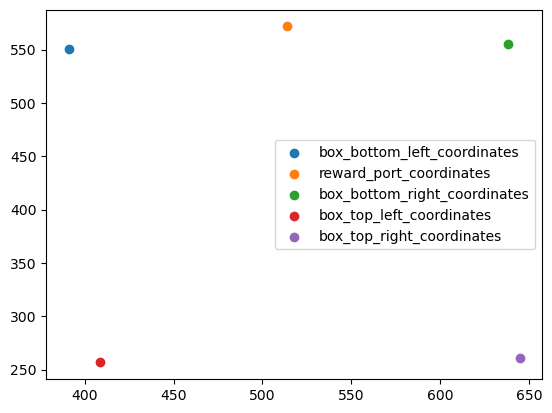

In [252]:
fig, ax = plt.subplots()

for index, row in tone_start_df.iterrows():
    for corner in corner_columns:
        plt.scatter(row[corner][0], row[corner][1], label=corner)
    break
plt.legend()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a4490980-3f6a-4f44-80eb-ebd789a5b21f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>